# Example: Neural Networks in larger models

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [38]:
using Flux
using Random
using Gogeta
using Plots
using Gurobi
using JuMP

In some of the previous examples, related to the neural networks we mentioned that we can add some additional constraints to formulation of the NN. In those examples, after formulation of the NN, we were manually extracting the needed input variables from the formulation. But in this Jupyter notebook, we are going to present a more efficient way how to use NN in larger optimization models.

## Some innitial constraints 

Let input variables are $x\in [-1.5, -0.5]$ and $y\in[-0.5,0.5]$. 

We also know that $y\geq -x-1$. 

There is also some arbitraty function $f(x,y)$ and we don't know it explicitly, but it can be represented by surrogate model - trained NN.

In [39]:
# Create a small neural network with random weights
begin
    Random.seed!(1234);

    NN_model = Chain(
        Dense(2 => 10, relu),
        Dense(10 => 50, relu),
        Dense(50 => 20, relu),
        Dense(20 => 5, relu),
        Dense(5 => 1)
    )
end

# Set upper and lower input bounds
init_U = [-0.5, 0.5];
init_L = [-1.5, -0.5];

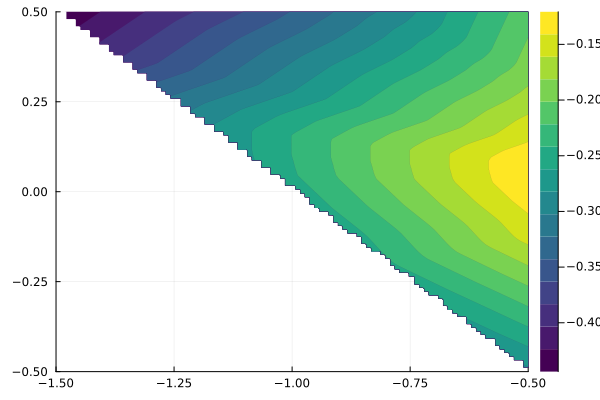

In [40]:
# contour plot the model in the feasible region of the following optimization problem
x_range = LinRange{Float32}(init_L[1], init_U[1], 100);
y_range = LinRange{Float32}(init_L[2], init_U[2], 100);

contourf(x_range, y_range, (x, y) -> if y >= -x-1 NN_model(hcat(x, y)')[] else NaN end, c=cgrad(:viridis), lw=0)


In [4]:
function NN_incorporate!(
    jump_original::JuMP.Model,
    param_source,
    output_var,
    input_vars...;
    U_in,
    L_in,
    compress=false,
    bound_tightening="fast",
    parallel=false,
    silent=false,
    U_out=nothing,
    L_out=nothing
)

    oldstdout = stdout
    if silent redirect_stdout(devnull) end

    W, b = if param_source isa String
        get_JSON_params(param_source)
    elseif param_source isa Flux.Chain
        get_Flux_params(param_source)
    else
        @error "Model must be either a Flux.Chain or a filepath containing a JSON file."
    end

    K = length(b)
    removed_neurons = Vector{Vector}(undef, K)
    [removed_neurons[layer] = Vector{Int}() for layer in 1:K]

    input_length = Int((length(W[1]) / length(b[1])))
    neuron_count = [length(b[k]) for k in eachindex(b)]
    neurons(layer) = layer == 0 ? [i for i in 1:input_length] : [i for i in setdiff(1:neuron_count[layer], removed_neurons[layer])]
    @assert input_length == length(U_in) == length(L_in) "Initial bounds arrays must be the same length as the input layer"
        
    U_bounds = Vector{Vector}(undef, K)
    L_bounds = Vector{Vector}(undef, K)

    jump_model = Model()
    if bound_tightening != "fast"
        Main.set_solver!(jump_model)
    
        @variable(jump_model, x[layer = 0:K, neurons(layer)])
        @variable(jump_model, s[layer = 1:K-1, neurons(layer)])
        @variable(jump_model, z[layer = 1:K-1, neurons(layer)], Bin)
            
        @constraint(jump_model, [j = 1:input_length], x[0, j] <= U_in[j])
        @constraint(jump_model, [j = 1:input_length], x[0, j] >= L_in[j])
    
        # upper bound and lower bound constraints for output bound tightening
        ucons = Vector{Vector{ConstraintRef}}(undef, K)
        lcons = Vector{Vector{ConstraintRef}}(undef, K)
    
        [ucons[layer] = Vector{ConstraintRef}(undef, neuron_count[layer]) for layer in 1:K]
        [lcons[layer] = Vector{ConstraintRef}(undef, neuron_count[layer]) for layer in 1:K]
    end

    layers_removed = 0 # how many strictly preceding layers have been removed at current loop iteration 

    for layer in 1:K # hidden layers and bounds for output layer

        println("LAYER: $layer")

        # compute loose bounds
        if layer - layers_removed == 1
            U_bounds[layer] = [sum(max(W[layer][neuron, previous] * U_in[previous], W[layer][neuron, previous] * L_in[previous]) for previous in neurons(layer-1-layers_removed)) + b[layer][neuron] for neuron in neurons(layer)]
            L_bounds[layer] = [sum(min(W[layer][neuron, previous] * U_in[previous], W[layer][neuron, previous] * L_in[previous]) for previous in neurons(layer-1-layers_removed)) + b[layer][neuron] for neuron in neurons(layer)]
        else
            U_bounds[layer] = [sum(max(W[layer][neuron, previous] * max(0, U_bounds[layer-1-layers_removed][previous]), W[layer][neuron, previous] * max(0, L_bounds[layer-1-layers_removed][previous])) for previous in neurons(layer-1-layers_removed)) + b[layer][neuron] for neuron in neurons(layer)]
            L_bounds[layer] = [sum(min(W[layer][neuron, previous] * max(0, U_bounds[layer-1-layers_removed][previous]), W[layer][neuron, previous] * max(0, L_bounds[layer-1-layers_removed][previous])) for previous in neurons(layer-1-layers_removed)) + b[layer][neuron] for neuron in neurons(layer)]
        end

        # compute tighter bounds
        if bound_tightening == "standard"
            bounds = if parallel == true # multiprocessing enabled
                pmap(neuron -> calculate_bounds(copy_model(jump_model), layer, neuron, W[layer], b[layer], neurons; layers_removed), neurons(layer))
            else
                map(neuron -> calculate_bounds(jump_model, layer, neuron, W[layer], b[layer], neurons; layers_removed), neurons(layer))
            end
            # only change if bound is improved
            U_bounds[layer] = min.(U_bounds[layer], [bound[1] for bound in bounds])
            L_bounds[layer] = max.(L_bounds[layer], [bound[2] for bound in bounds])
        end

        # output bounds calculated but no more constraints added
        if layer == K
            break
        end

        if compress 
            layers_removed = prune!(W, b, removed_neurons, layers_removed, neuron_count, layer, U_bounds, L_bounds) 
        end

        if bound_tightening != "fast"
            for neuron in neurons(layer)
                @constraint(jump_model, x[layer, neuron] >= 0)
                @constraint(jump_model, s[layer, neuron] >= 0)

                ucons[layer][neuron] = @constraint(jump_model, x[layer, neuron] <= max(0, U_bounds[layer][neuron]) * z[layer, neuron])
                lcons[layer][neuron] = @constraint(jump_model, s[layer, neuron] <= max(0, -L_bounds[layer][neuron]) * (1-z[layer, neuron]))

                @constraint(jump_model, x[layer, neuron] - s[layer, neuron] == b[layer][neuron] + sum(W[layer][neuron, i] * x[layer-1-layers_removed, i] for i in neurons(layer-1-layers_removed)))
            end
        end

        if length(neurons(layer)) > 0
            layers_removed = 0
        end 

    end
    
    # using output bounds in bound tightening
    if bound_tightening == "output"  
        # output layer
        @constraint(jump_model, [neuron in neurons(K)], x[K, neuron] == b[K][neuron] + sum(W[K][neuron, i] * x[K-1-layers_removed, i] for i in neurons(K-1-layers_removed)))

        @assert length(L_out) == length(U_out) == neuron_count[K] "Incorrect length of output bounds array."

        @constraint(jump_model, [neuron in 1:neuron_count[K]], x[K, neuron] >= L_out[neuron])
        @constraint(jump_model, [neuron in 1:neuron_count[K]], x[K, neuron] <= U_out[neuron])

        println("LAYER: $layer")

        for layer in 1:K-1

            bounds = if parallel == true # multiprocessing enabled
                pmap(neuron -> calculate_bounds(copy_model(jump_model), layer, neuron, W[layer], b[layer], neurons; layers_removed), neurons(layer))
            else
                map(neuron -> calculate_bounds(jump_model, layer, neuron, W[layer], b[layer], neurons; layers_removed), neurons(layer))
            end

            # only change if bound is improved
            U_bounds[layer] = min.(U_bounds[layer], [bound[1] for bound in bounds])
            L_bounds[layer] = max.(L_bounds[layer], [bound[2] for bound in bounds])

            for neuron in neuron_count[layer]

                delete(jump_model, ucons[layer][neuron])
                delete(jump_model, lcons[layer][neuron])

                @constraint(jump_model, x[layer, neuron] <= max(0, U_bounds[layer][neuron]) * (1 - z[layer, neuron]))
                @constraint(jump_model, s[layer, neuron] <= max(0, -L_bounds[layer][neuron]) * z[layer, neuron])
            end

        end

        U_bounds[K] = U_out
        L_bounds[K] = L_out
    end

    # incorporate NN formulation into original JuMP model using bounds that have just been computed
    if compress
        new_model = build_model!(W, b, K, neurons)
        W, b = get_Flux_params(new_model)

        U_compressed = [U_bounds[layer][neurons(layer)] for layer in 1:K]
        filter!(neurons -> length(neurons) != 0, U_compressed)

        L_compressed = [L_bounds[layer][neurons(layer)] for layer in 1:K]
        filter!(neurons -> length(neurons) != 0, L_compressed)

        U_bounds = U_compressed
        L_bounds = L_compressed
    end

    anon_NN_from_bounds!(jump_original, W, b, output_var, input_vars...; U_in, L_in, U_bounds, L_bounds)

    redirect_stdout(oldstdout)

end

"""
    function anon_NN_from_bounds!(jump::JuMP.Model, W, b, output_var, input_vars...; U_in, L_in, U_bounds, L_bounds)

Helper function for anonymously formulating the NN into a JuMP model given weights, biases and the variable references to be linked.
"""
function anon_NN_from_bounds!(jump::JuMP.Model, W, b, output_var, input_vars...; U_in, L_in, U_bounds, L_bounds)

    layers = 1:length(b)
    n_neurons = Dict{Int, Int}()
    n_neurons[0] = length(U_in)
    [n_neurons[layer] = length(b[layer]) for layer in layers]

    x = @variable(jump, [layer=union(0, layers), 1:n_neurons[layer]])
    s = @variable(jump, [layer=layers[1:end-1], 1:n_neurons[layer]])
    z = @variable(jump, [layer=layers[1:end-1], 1:n_neurons[layer]])
    @constraint(jump, [layer=layers[1:end-1], neuron=1:n_neurons[layer]], x[layer, neuron] >= 0)
    @constraint(jump, [layer=layers[1:end-1], neuron=1:n_neurons[layer]], s[layer, neuron] >= 0)

    input = [var for var in input_vars]
    @constraint(jump, [neuron=1:n_neurons[0]], x[0, neuron] == input[neuron])
    @constraint(jump, [neuron=1:n_neurons[0]], L_in[neuron] <= x[0, neuron] <= U_in[neuron])

    for layer in layers # 1...last layer

        for neuron in 1:n_neurons[layer]
            
            FC_sum = @expression(jump, sum(W[layer][neuron, neuron_last] * x[layer-1, neuron_last] for neuron_last in 1:n_neurons[layer-1]))
            bias = b[layer][neuron]
            
            if layer == maximum(layers)
                @constraint(jump, x[layer, neuron] == FC_sum + bias)
                break
            end

            set_binary(z[layer, neuron])
            @constraint(jump, x[layer, neuron] <= max(0, U_bounds[layer][neuron]) * z[layer, neuron])
            @constraint(jump, s[layer, neuron] <= max(0, -L_bounds[layer][neuron]) * (1-z[layer, neuron]))

            @constraint(jump, x[layer, neuron] - s[layer, neuron] == FC_sum + bias)
        end
    end

    # reference to output variable
    @constraint(jump, output_var == x[maximum(layers), 1])

end

"""
    function forward_pass_NN!(jump, input, output_var, input_vars)

Calculates the forward pass through the NN (the output that is produced with the given input).
This function can be used when the NN formulation is incorporated into a larger optimization problem.

# Arguments

- `jump`: JuMP model with the NN formulation
- `input`: value to be forward passed
- `output_var`: reference to the NN output variable
- `input_vars`: references to the NN input variables

"""
function forward_pass_NN!(jump, input, output_var, input_vars...)

    input_var = [var for var in input_vars]
    [fix(input_var[neuron], input[neuron], force=true) for neuron in eachindex(input)]
    
    try
        optimize!(jump)
        return value(output_var)
    catch e
        println("Error with forward pass: $e")
        @warn "Input or output outside of bounds or incorrectly constructed model."
        return NaN
    end
end

"""
    function get_Flux_params(NN_model::Flux.Chain)

Helper function for getting the necessary parameters out of a Flux.Chain model.
Returns the weights and the biases as vectors.
"""
function get_Flux_params(NN_model::Flux.Chain)

    K = length(NN_model) # number of layers (input layer not included)
    W = deepcopy([Flux.params(NN_model)[2*k-1] for k in 1:K])
    b = deepcopy([Flux.params(NN_model)[2*k] for k in 1:K])

    @assert all([NN_model[i].σ == relu for i in 1:K-1]) "Neural network must use the relu activation function."
    @assert NN_model[K].σ == identity "Neural network must use the identity function for the output layer."

    return W, b
end

"""
    function get_JSON_params(filepath::String)

Helper function for getting the necessary parameters out of a JSON file.
Returns the weights and the biases as vectors.
"""
function get_JSON_params(filepath::String)

    params = JSON.parsefile(filepath)
    # Weights: W[layer name][1][column num][row]
    # Biases: W[layer name][2][bias index]
    # names FC-1,2,...,k (fully connected)
    #       (k is output layer index)

    layers = parse.(Int, last.(filter(key -> occursin("FC", key), keys(params)))) # FC indices
    sort!(layers)

    W = [params["FC"*string(layer)][1] for layer in layers]
    b = [params["FC"*string(layer)][2] for layer in layers]

    W = [reduce(hcat, W[layer]) for layer in layers]

    return W, b

end

function calculate_bounds(model::JuMP.Model, layer, neuron, W, b, neurons; layers_removed=0)

    @objective(model, Max, b[neuron] + sum(W[neuron, i] * model[:x][layer-1-layers_removed, i] for i in neurons(layer-1-layers_removed)))
    optimize!(model)
    
    upper_bound = if termination_status(model) == OPTIMAL
        objective_value(model)
    else
        @warn "Layer $layer, neuron $neuron could not be solved to optimality."
        objective_bound(model)
    end

    set_objective_sense(model, MIN_SENSE)
    optimize!(model)
 
    lower_bound = if termination_status(model) == OPTIMAL
        objective_value(model)
    else
        @warn "Layer $layer, neuron $neuron could not be solved to optimality."
        objective_bound(model)
    end

    println("Neuron: $neuron, bounds: [$lower_bound, $upper_bound]")

    return upper_bound, lower_bound
end

calculate_bounds (generic function with 1 method)

Create `JuMP` model

In [53]:
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


Add varible that would be associated with neural network output

In [54]:
@variable(jump_model, output);

Add input variables

In [55]:
@variable(jump_model, x);
@variable(jump_model, y);

Add some additional constraints associated with input variables

In [56]:
@constraint(jump_model, y >= -x - 1);

The objective function can be anything you want. Suppose, you want to find $$\text{max } f(x,y) - 0.5x$$

In [57]:
@objective(jump_model, Max, output - 0.5*x);

Don't forget to set up sover

In [58]:
function set_solver!(jump)
    set_optimizer(jump, () -> Gurobi.Optimizer())
    set_silent(jump)
end

set_solver! (generic function with 1 method)

Arguments

- `jump_original`: JuMP model into which the neural network MIP should be incorporated
- `param_source`: relative path to the JSON file containing the model parameters OR a Flux.Chain model
- `output_var`: reference to the variable that should be linked to the NN output
- `input_vars`: references to the variables that will be used as the NN inputs

Keyword Arguments

- `U_in`: vector of upper bounds for the input variables
- `L_in`: vector of lower bounds for the input variables
- `compress`: reduce NN size by removing stable and linearly dependent neurons
- `bound_tightening`: which bound tightening mode to use: "fast", "standard", "output"
- `parallel`: use multiprocessing for bound tightening
- `silent`: suppress console output
- `U_out`: vector of upper bounds for the output variables - necessary when output bound tightening is used
- `L_out`: vector of lower bounds for the output variables - necessary when output bound tightening is used

In [59]:
NN_incorporate!(jump_model, NN_model, output, x, y; U_in=init_U, L_in=init_L, bound_tightening="standard", silent=true)

IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting)))

In [60]:
jump_model

A JuMP Model
Maximization problem with:
Variables: 261
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 89 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 171 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 170 constraints
`AffExpr`-in-`MathOptInterface.Interval{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 85 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: output, x, y

In [62]:
optimize!(jump_model)
x_opt = value(x)
y_opt = value(y)

println("Solution:")
println("x = ", x_opt)
println("y = " , y_opt)

Solution:
x = -1.2609439405453131
y = 0.2609439405453131


In [63]:
solution_summary(jump_model)

* Solver : Gurobi

* Status
  Result count       : 3
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 3.09040e-01
  Objective bound    : 3.09066e-01
  Relative gap       : 8.35390e-05
  Dual objective value : 3.09066e-01

* Work counters
  Solve time (sec)   : 5.40972e-04
  Barrier iterations : 0
  Node count         : 1


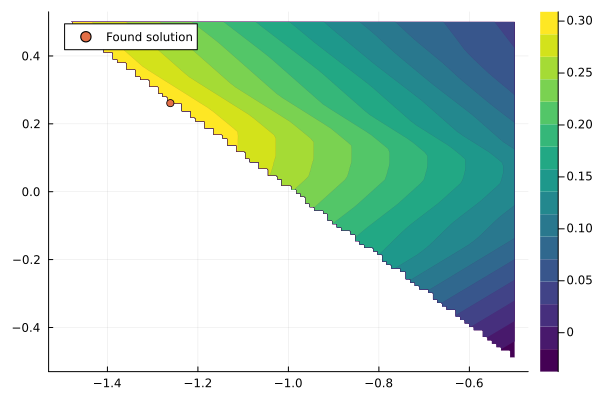

In [64]:
contourf(x_range, y_range, (x_in, y_in) -> if y_in >= -x_in-1 forward_pass_NN!(jump_model, [x_in, y_in], output, x, y) - 0.5 *x_in else NaN end, c=cgrad(:viridis), lw=0)
scatter!([x_opt], [y_opt], label="Found solution")

In [65]:
# check that NN formulation matches Flux model
set_silent(jump_model)
check = [if y_in >= -x_in-1 forward_pass_NN!(jump_model, [x_in, y_in], output, x, y) ≈ NN_model(hcat(x_in, y_in)')[] end for x_in in x_range, y_in in y_range]
all(value -> value === nothing || value == true, check)

true